In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using RData
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase
using NFFT
using Plots

In [3]:
# Import data
raw_data = load("./Data/longitudinal.RData")
proj_time = raw_data["proj_time"]
first(proj_time, 5)

Row,otu_id,count,project_id,sample_id,run_id,classification,host_id,host_age,date_collection,experiment_day,samplesite,nreads
,Int32,Float64,String,String,String,Cat…,Cat…,Float64,Cat…,Int32,Cat…,Float64
1,103181,21.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
2,219738,19.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
3,261104,1.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
4,47921,5.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
5,5336,471.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0


**project_id**: identifies projects\
**classification**: identifies the environments considered within a project\
**samplesite**: identifies the specific site from which a sample is taken\
**sample_id**: identifies samples (communities) gathered within the same environment\
**run_id**: identifies the machine run to identify species in a sample. Multiple runs are possible within the same sample\
**otu_id**: identifies species\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run\
**host_id**: identifies host of the sample\
**host_age**: age of the host\
**date_collection**: day of sample collection in format YYY-MM-DD\
**experiment_day**: day passed from the beginning of data collection\

In [4]:
# Some environments have 'nreads' and 'count' inverted (I suppose) so they need to be fixed
mask = proj_time.nreads .< proj_time.count
for i in eachindex(mask)
    if mask[i]
        tmp = proj_time.nreads[i]
        proj_time.nreads[i] = proj_time.count[i]
        proj_time.count[i] = tmp
    end
end

# Further analysis is done only for environments with a 'sufficient' number of samples and
# for runs which detected a 'sufficient' number of reads (I don't know if the order of these operations is important)
min_samples = 1
min_nreads = 1
grouped = groupby(proj_time, :project_id)
filtered_data = combine(grouped) do sdf
    if length(unique(sdf.sample_id)) > min_samples
        return sdf
    else
        return DataFrame()
    end
end

# Keep only rows with nreads > min_nreads
filtered_data = filtered_data[filtered_data.nreads .> min_nreads, :]

# Drop unnecessary columns
select!(filtered_data, Not([:host_age, :date_collection]))

# In the dataset there are only two host_ids which are 'M3' and 'F4'. The first one have been studied for six months while
# the second have been sampled for three days. I reduce the analysis for the first and in case I will return on the other later
filtered_data = filtered_data[filtered_data.host_id .== "M3", :];

In [5]:
# Divide data for different environments
FECES = filtered_data[filtered_data.classification .== "feces", :]
ORALCAVITY = filtered_data[filtered_data.classification .== "oralcavity", :]
SKIN = filtered_data[filtered_data.classification .== "skin", :]

# Drop 'classification' column and compute frequencies
dfs = [FECES, ORALCAVITY, SKIN]

for i in 1:length(dfs)
    df = deepcopy(dfs[i])  # Make a copy
    select!(df, Not(:classification))  # Drop column
    df.f = df.count ./ df.nreads       # Compute frequency
    dfs[i] = df                        # Store back into the array
end

# Extract all environments
# NOTE: Each environment can still have samples from different projects. Since I don't have any information about 
#       the specific methodologies used in different experiments, I treat them as statistically equivalent.
FECES, ORALCAVITY, SKIN = dfs;


In [27]:
# Restrict to a specific environment
# df = FECES
df = ORALCAVITY
# df = SKIN[SKIN.samplesite .== "R_palm", :]
# df = SKIN[SKIN.samplesite .== "L_palm", :]

# For each sample, average 'f' across different runs
df = combine(groupby(df, [:otu_id, :sample_id])) do sdf
    DataFrame(
        otu_id = sdf.otu_id[1],
        sample_id = sdf.sample_id[1],
        experiment_day = sdf.experiment_day[1],
        f = mean(sdf.f),
        project_id = sdf.project_id[1],
        host_id = sdf.host_id[1],
    )
end

# For each day, average 'f' across different samples
df = combine(groupby(df, [:otu_id, :experiment_day])) do sdf
    DataFrame(
        otu_id = sdf.otu_id[1],
        experiment_day = sdf.experiment_day[1],
        f = mean(sdf.f)
    )
end;

# PSD analysis using NFFT

The goal is to find the slope of the PWD as it gives an idea of the type of noise to which the signal is subjected. Before doing that I need to further filter the data as many subsequent days are missing. With the usage of NFFT this should be a problem but maybe too many subsequent missing days can generate some biases. To avoid this I consider the longest time window with (almost) subsequent days.

In [28]:
# Since some days are missing, I filter again the df to only consider the species that are present in the 
# largest window of (almost) subsequent days

function consecutive_window(data::Vector{<:Integer}, n::Integer = 0)
    if isempty(data)
        return Integer[]
    end
    out1 = [data[1]]
    out2 = Integer[]
    for (i, d) in enumerate(data[2:end])
        if d - out1[end] <= n + 1
            push!(out1, d)
        else
            out2 = consecutive_window(data[i+1:end], n)
            break
        end
    end
    return length(out1) >= length(out2) ? out1 : out2
end

# Find the largest time window considering a maximum gap of 'daygap' days
daygap = 3
unique_days = unique(df.experiment_day)
sort!(unique_days)
window = consecutive_window(unique_days, daygap)

# Filter to consider only rows with experiment_day in the selected window and reorder them
df_subset = filter(row -> in(row.experiment_day, window), df)
sort!(df_subset, :experiment_day);

In [29]:
# Set paramas and variables to perform NFFT
Δt = 1
N = Int64(maximum(window) - minimum(window))
N_min = N / 2 # The analysis will consider only those species that are present in a 'sufficient' number of samples
Nf = Δt / 2 # Since sample rate is 1 day
frequencies = range(-Nf, stop=Nf, length=N) # Frequency domain

println("Window length:  $N")

mean_S = zeros(N) # Initialize array
otu_count = 0 # Needed for normalization
otu_ids = unique(df_subset.otu_id) # Get otu_ids
for otu in otu_ids
    t_indices = collect(filter(row -> row.otu_id == otu, df_subset).experiment_day)
    t_normalized = (t_indices .- minimum(window)) ./ N .- 0.5  # The algorithm work for t ∈ [-0.5, 0.5)
    x = log.(collect(filter(row -> row.otu_id == otu, df_subset).f))
    x .-= mean(x) # Detrend signal to avoid peak at zero frequency and have comparable signals
    
    # Compute non-uniform FFT only for a 'sufficient' number of samples
    if length(t_indices) > N_min
        otu_count += 1
        p_nfft = NFFT.plan_nfft(t_normalized, N, reltol=1e-9)
        fhat = adjoint(p_nfft) * x
    
        # Compute normalized power spectrum density (periodogram)
        S = abs2.(fhat) .* (Δt / (2*N + 1))
        mean_S .+= S # Mean PSD: this step should give a more accurate result for the PSD supposing that all trajectories are equivalent
    end
end

println("OTUs considered:  $otu_count")

# Take only positive frequencies
fc = findfirst(x -> x > 0, frequencies)
frequencies = frequencies[fc:end]
mean_S = mean_S[fc:end] ./ otu_count;

Window length:  308
OTUs considered:  69


Estimated slope: -0.4921728493963958
Intercept: -1.0385412578978859


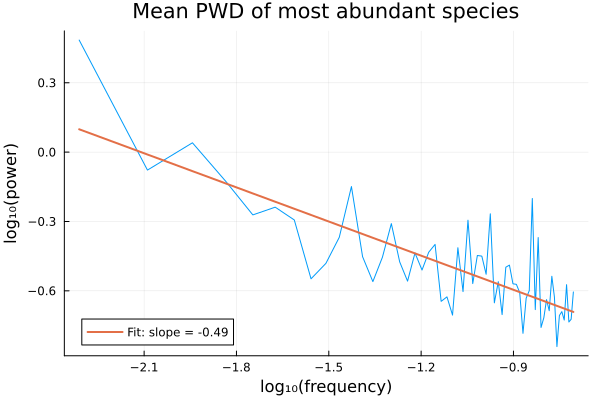

In [30]:
# Filter frequencies to avoid bias at too low and too high frequencies
# Essentially the fact the we have linear frequency binning but we compute the slope in log-log space creates problems
# at very low freqs because there are less points and at very high freqs because there are too many points. Moreover these
# methods are exact only in the infinite time case so we need to consider border effects.
mask = (frequencies .> 1 / N) .& (frequencies .< 0.2)
frequencies = frequencies[mask]
mean_S = mean_S[mask]

# Take logs
log_f = log10.(frequencies)
log_S = log10.(mean_S)

# Put into a DataFrame and fit linear model: log_S ~ log_k
plot_df = DataFrame(log_f=log_f, log_S=log_S)
model = lm(@formula(log_S ~ log_f), plot_df)

# Extract the slope and intercept
coeffs = coef(model)
slope = coeffs[2]
intercept = coeffs[1]

println("Estimated slope: ", slope)
println("Intercept: ", intercept)

# Plot results
plot(log_f, log_S, label=:none, xlabel="log₁₀(frequency)", ylabel="log₁₀(power)", legend=:bottomleft,
    title="Mean PWD of most abundant species")
plot!(log_f, predict(model), label="Fit: slope = $(round(slope, digits=2))", lw=2)

In [31]:
# savefig("./Images/psd_L_PALM.png")